In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import nltk
import spacy
from nltk import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
df = pd.read_csv('Quora question pairs train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


1 null value in question1  
2 null values in question2

In [5]:
df.describe()

,id,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000,404290.000000
mean,202144.500000,217243.942418,220955.655337,0.369198
std,116708.614503,157751.700002,159903.182629,0.482588
min,0.000000,1.000000,2.000000,0.000000
25%,101072.250000,74437.500000,74727.000000,0.000000
50%,202144.500000,192182.000000,197052.000000,0.000000
75%,303216.750000,346573.500000,354692.500000,1.000000
max,404289.000000,537932.000000,537933.000000,1.000000


In [6]:
df.dropna(inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


In [8]:
# choosing a small sample of questions to make the computations fast
df = df.sample(10000).reset_index(drop=True)

In [9]:
total_questions = pd.concat([df['question1'],df['question2']])

is_duplicate
0    6272
1    3728
Name: count, dtype: int64


<Axes: title={'center': 'Percentage of duplicate questions'}, ylabel='count'>

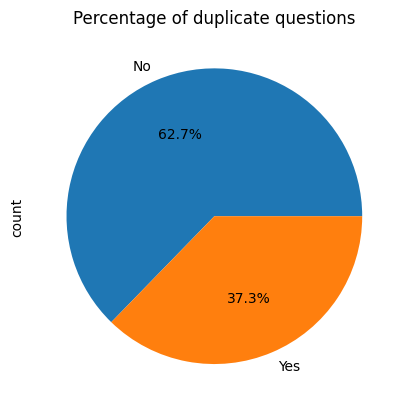

In [10]:
print(df['is_duplicate'].value_counts())
df['is_duplicate'].value_counts().plot(kind='pie',labels=['No','Yes'],autopct='%1.1f%%',title='Percentage of duplicate questions')

### Feature Engineering

In [11]:
import re
def preprocess(question):

    # converting the questions to lowercase to handle case senstivity and trimming to remove unnecessary spaces
    question = question.lower().strip()

    # removing html tags
    question = re.sub('<.*?>','',question).strip()

    #removing url tags
    question = re.sub(r'https?://(?:www\.)?\S+|www\.\S+', '', question).strip()

    # Replace certain special characters with their string equivalents
    question = question.replace('%', ' percent')
    question = question.replace('$', ' dollar ')
    question = question.replace('₹', ' rupee ')
    question = question.replace('€', ' euro ')
    question = question.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    question = question.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    question = question.replace(',000,000,000 ', 'b ')
    question = question.replace(',000,000 ', 'm ')
    question = question.replace(',000 ', 'k ')
    question = re.sub(r'([0-9]+)000000000', r'\1b', question)
    question = re.sub(r'([0-9]+)000000', r'\1m', question)
    question = re.sub(r'([0-9]+)000', r'\1k', question)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in question.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    question = ' '.join(q_decontracted)
    question = question.replace("'ve", " have")
    question = question.replace("n't", " not")
    question = question.replace("'re", " are")
    question = question.replace("'ll", " will")
    
    return question

In [12]:
preprocess('This is <h1>a good sign </h1> https://www.anna.com www.kaggle.com http://mydomain.org www.kaggle.com/code/mohitkumar282/quora-duplicate-questions/edit')

'this is a good sign'

In [13]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [14]:
nlp = spacy.load('en_core_web_sm')

def lemmatization(question):
    doc = nlp(question)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return (" ".join(lemmatized_tokens))

In [15]:
df['question1'] = df['question1'].apply(lemmatization).str.replace('?','').str.strip()
df['question2'] = df['question2'].apply(lemmatization).str.replace('?','').str.strip()

In [16]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,382770,514658,514659,which of the follow approach be in line with a...,what be most appropriate software design appro...,0
1,362186,139911,3848,how can I enlarge my penis,how can I have a big penis,1
2,212579,41575,48103,be we on the brink of a third world war,how close we be to see 3rd world war,1
3,277779,396943,396944,who be the good philosopher of all time and why,who do you think be the good influential philo...,0
4,286140,356098,406656,why do not many people from tamilnadu support ...,why do people in tamilnadu not like narendra modi,1


In [17]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [18]:
df['q1_num_words'] = df['question1'].apply(lambda x: len(x.split()))
df['q2_num_words'] = df['question2'].apply(lambda x: len(x.split()))

In [19]:
def common_words(row):
    #map(function, iterable)
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [20]:
df['common_words'] = df.apply(common_words, axis=1)

In [21]:
def total_words(row):
    w1 = set(map((lambda x: x.lower().strip()), row['question1'].split()))
    w2 = set(map((lambda x: x.lower().strip()), row['question2'].split()))
    return len(w1) + len(w2)

In [22]:
df['total_words'] = df.apply(total_words, axis=1)

In [23]:
df['words_share'] = round(df['common_words'] / df['total_words'],2)

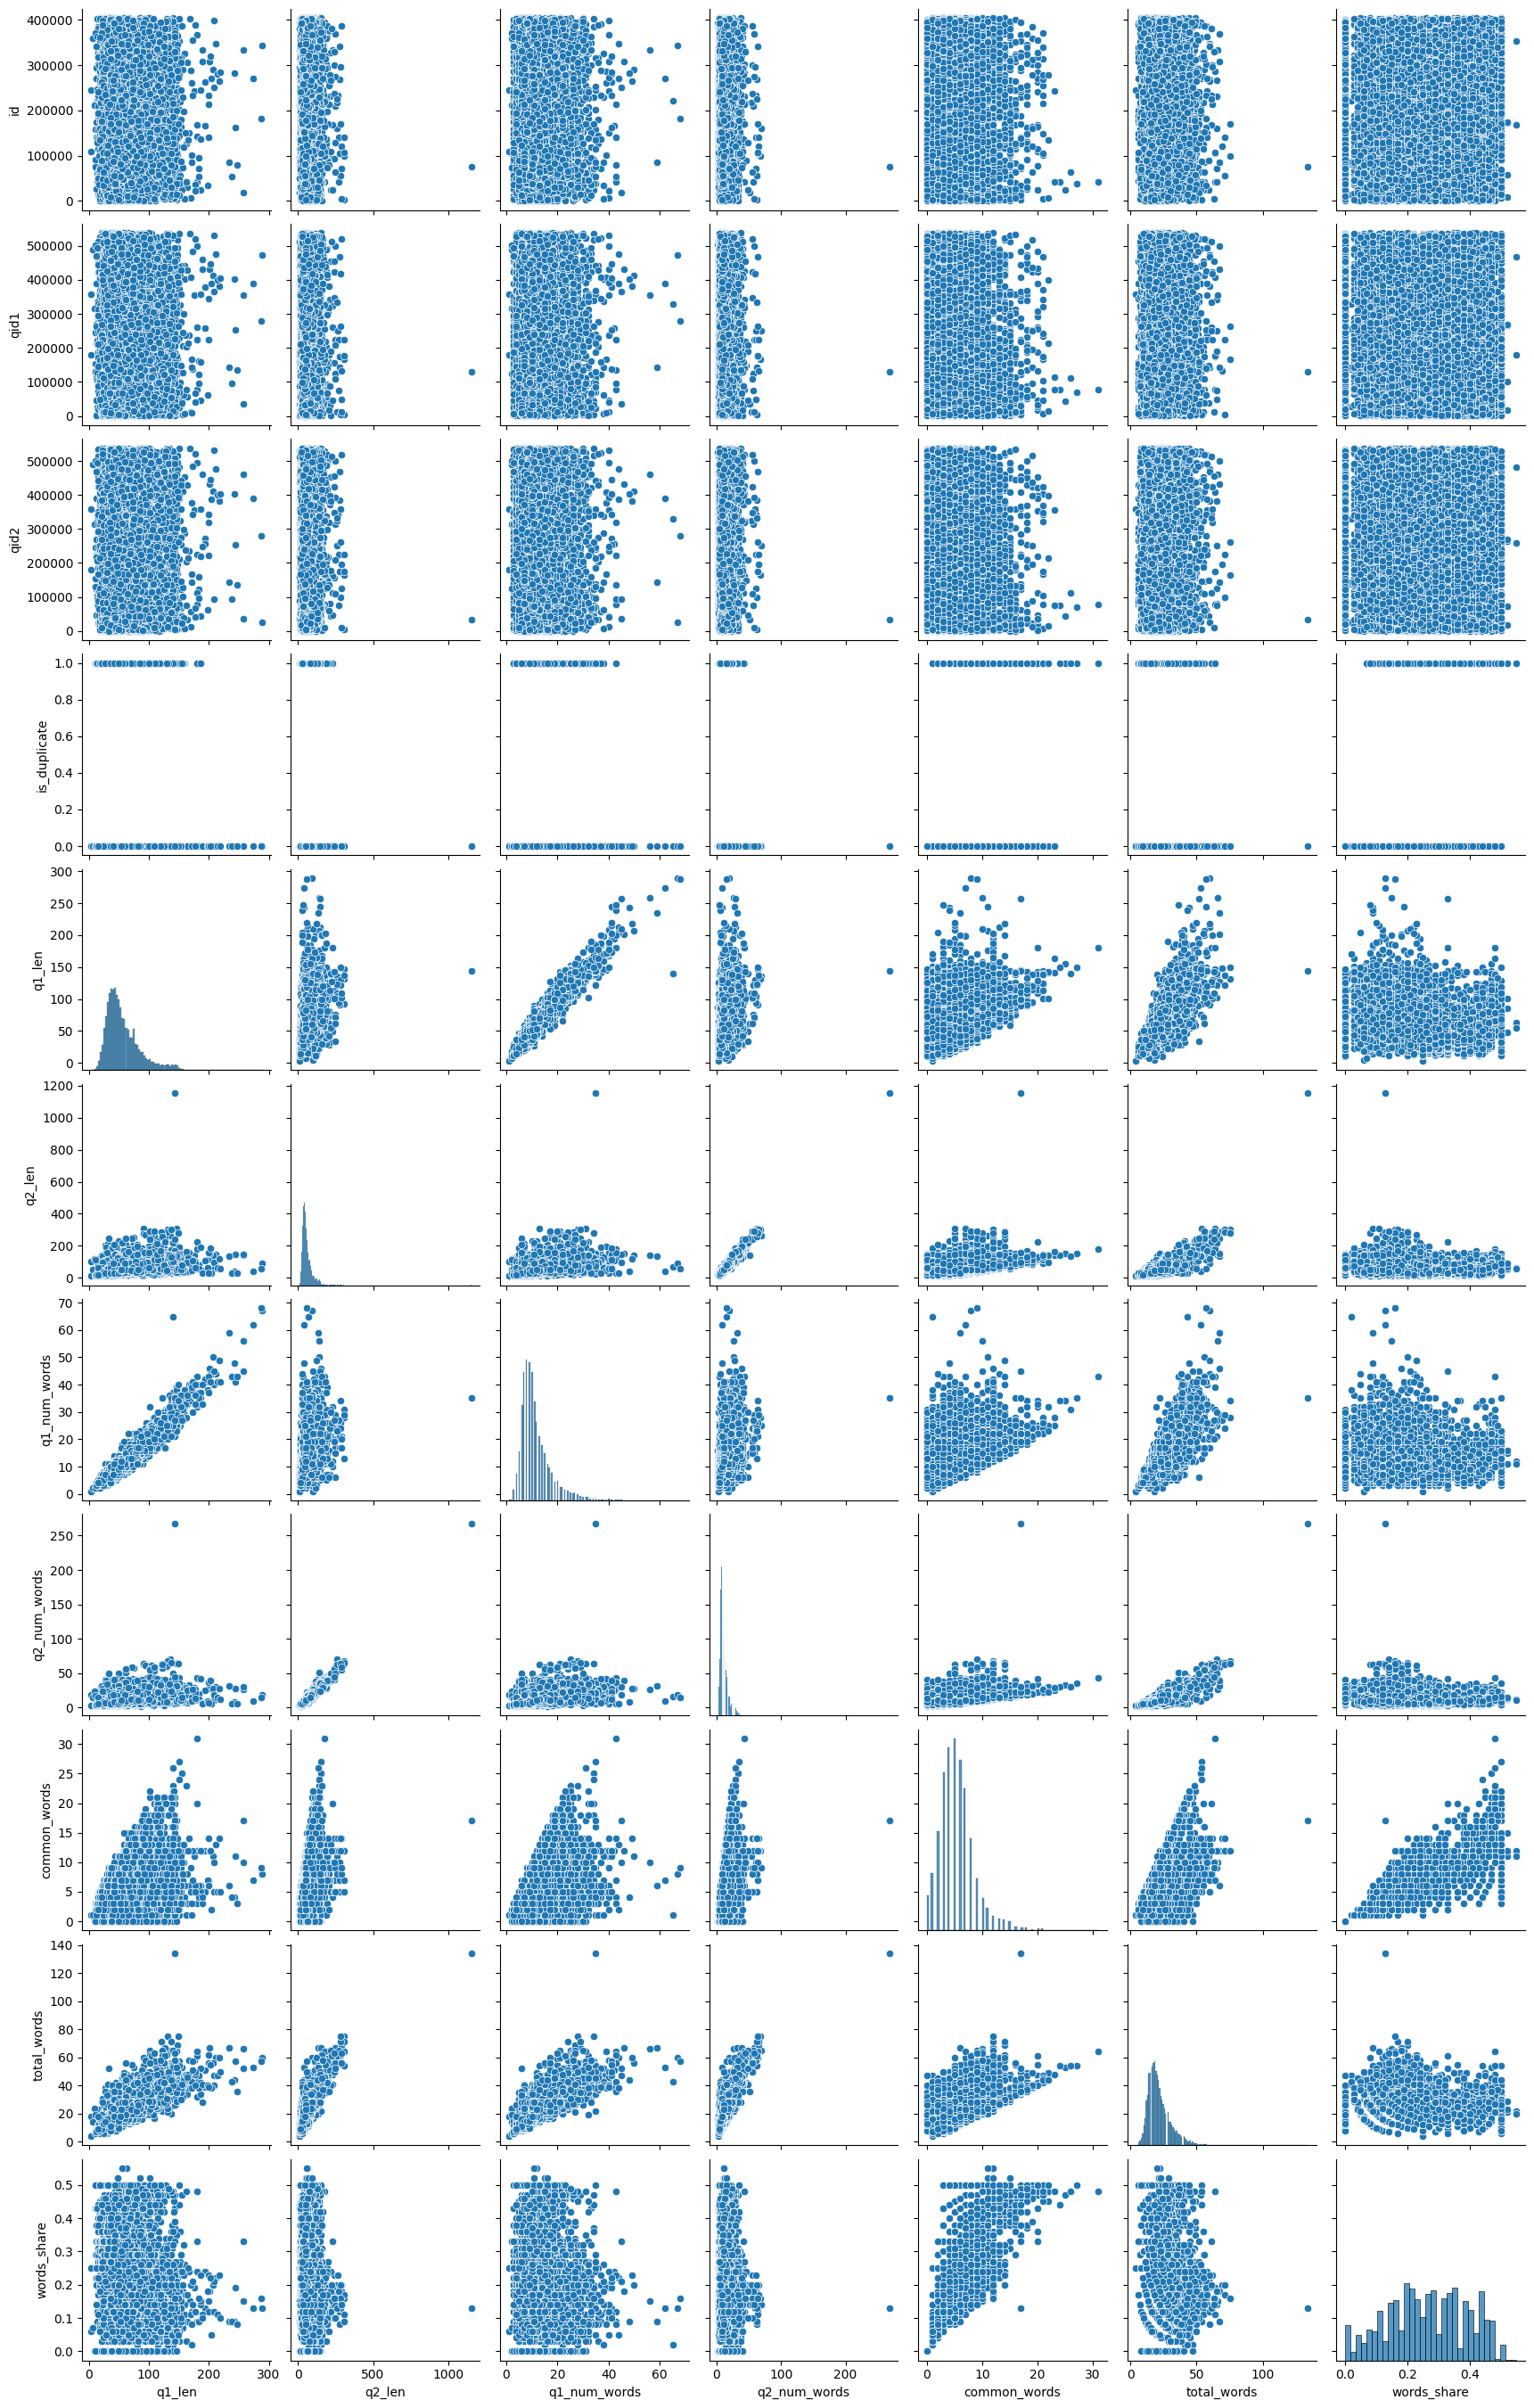

In [24]:
sns.pairplot(data = df, x_vars=['q1_len', 'q2_len', 'q1_num_words', 'q2_num_words','common_words','total_words','words_share'],hue_order='is_duplicate')

In [25]:
tfidf = TfidfVectorizer()

transformed_text = tfidf.fit_transform(list(df['question1']) + list(df['question2']))

features1, features2 = np.vsplit(transformed_text.toarray(),2)

temp_df1 = pd.DataFrame(features1)
temp_df2 = pd.DataFrame(features2)

temp_df1.columns = [f"q1_{col}" for col in temp_df1.columns]
temp_df2.columns = [f"q2_{col}" for col in temp_df2.columns]

In [26]:
df = pd.concat([df, temp_df1, temp_df2],axis = 1)

In [27]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,q2_12279,q2_12280,q2_12281,q2_12282,q2_12283,q2_12284,q2_12285,q2_12286,q2_12287,q2_12288
0,382770,514658,514659,which of the follow approach be in line with a...,what be most appropriate software design appro...,0,95,126,17,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,362186,139911,3848,how can I enlarge my penis,how can I have a big penis,1,26,26,6,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
X = df.drop(columns=['id','qid1','qid2','question1','question2','is_duplicate'])
y = df['is_duplicate']

In [29]:
X.columns = X.columns.astype('str')
X.head()

,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,words_share,q1_0,q1_1,q1_2,...,q2_12279,q2_12280,q2_12281,q2_12282,q2_12283,q2_12284,q2_12285,q2_12286,q2_12287,q2_12288
0,95,126,17,23,5,38,0.13,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,26,26,6,7,4,13,0.31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,39,36,10,9,4,19,0.21,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47,64,10,12,8,22,0.36,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73,49,12,9,7,21,0.33,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=13)

print(y_train.shape, y_test.shape)

(8000,) (2000,)


## Evaluating different ML models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Dictionary of models to test
models = {
    'XGBoost': XGBClassifier(),
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(),
    'LogisticRegression': LogisticRegression(),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier()
}

# Iterate through each model and evaluate
for model_name, model in models.items():
    print(f"Training and evaluating: {model_name}")
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    predictions = model.predict(X_test)
    
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy for {model_name}: {accuracy}")
    print("-" * 40)


Training and evaluating: XGBoost
Accuracy for XGBoost: 0.7295
----------------------------------------
Training and evaluating: RandomForest
Accuracy for RandomForest: 0.73
----------------------------------------
Training and evaluating: SVM
